# Audio Baseline

In [8]:
import glob
import librosa
import copy
import torch
import numpy as np
import seaborn as sns
from torch.utils.data import Dataset
import pandas as pd
from torch import nn
from tqdm import tqdm_notebook 
import torch.nn.functional as F
import torch.optim as optim

## Data loading

In [9]:
DATA_FOLDER_PTH=os.path.join(os.getcwd(), os.pardir, 'data')


# processed
TRAIN_AUDIO_FOLDER_PTH=os.path.join(DATA_FOLDER_PTH, 'processed/MELD/train_wavs')
TRAIN_TEXT_FILE_PTH=os.path.join(DATA_FOLDER_PTH, 'raw/MELD/train', 'train_sent_emo.csv')


# pths
org_train_audio_pths=glob.glob(os.path.join(TRAIN_AUDIO_FOLDER_PTH, '*.wav'))

# making train and dev out of org_train
split_idx=int(len(org_train_audio_pths)*0.8)
train_audio_pths=org_train_audio_pths[:split_idx]
val_audio_pths=org_train_audio_pths[split_idx:]

print(len(train_audio_pths))
print(len(val_audio_pths))

7990
1998


In [10]:
train_text=pd.read_csv(TRAIN_TEXT_FILE_PTH)
train_text.head()

,Sr No.,Utterance,Speaker,Emotion,Sentiment,Dialogue_ID,Utterance_ID,Season,Episode,StartTime,EndTime
0,1,also I was the point person on my companys tr...,Chandler,neutral,neutral,0,0,8,21,"00:16:16,059","00:16:21,731"
1,2,You mustve had your hands full.,The Interviewer,neutral,neutral,0,1,8,21,"00:16:21,940","00:16:23,442"
2,3,That I did. That I did.,Chandler,neutral,neutral,0,2,8,21,"00:16:23,442","00:16:26,389"
3,4,So lets talk a little bit about your duties.,The Interviewer,neutral,neutral,0,3,8,21,"00:16:26,820","00:16:29,572"
4,5,My duties? All right.,Chandler,surprise,positive,0,4,8,21,"00:16:34,452","00:16:40,917"


<AxesSubplot:xlabel='Emotion', ylabel='Count'>

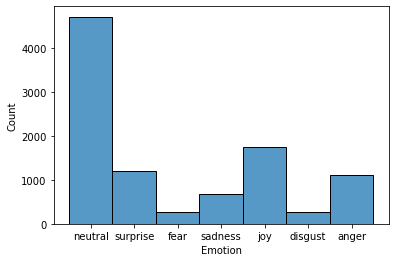

In [11]:
sns.histplot(data=train_text['Emotion'])

<AxesSubplot:xlabel='Sentiment', ylabel='Count'>

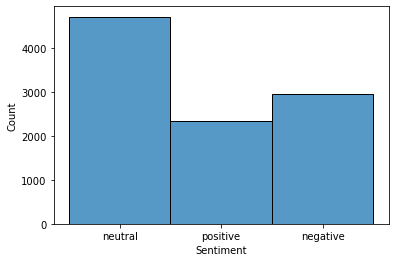

In [12]:
sns.histplot(data=train_text['Sentiment'])

In [ ]:
train_text['Emotion'].nunique()

#compute class weights
class_weights=1/ (train_text['Emotion'].value_counts()/len(train_text['Emotion']))
print(class_weights)

In [ ]:
def info_to_wav_name(dialogue_id, utterance_id):
    return 'dia{}_utt{}.wav'.format(dialogue_id, utterance_id)

def emotion_to_label(emotion):
    if emotion=='neutral':
        return 0
    elif emotion=='surprise':
        return 1
    elif emotion=='fear':
        return 2
    elif emotion=='sadness':
        return 3
    elif emotion=='joy':
        return 4
    elif emotion=='disgust':
        return 5
    elif emotion=='anger':
        return 6

train_text['wav_name']=train_text.apply(lambda x: info_to_wav_name(x['Dialogue_ID'], x['Utterance_ID']), axis=1)
train_text['label']=train_text.apply(lambda x: emotion_to_label(x['Emotion']), axis=1)
train_text.head()

In [ ]:
train_text['Emotion'].unique()

In [ ]:
wav_to_label=dict(zip(train_text['wav_name'], train_text['label']))
print(wav_to_label['dia0_utt0.wav'])

## Feature Extraction Testing (librosa)

In [ ]:
max_length=10
sr=8000
sample, sample_rate=librosa.load(train_audio_pths[30], sr=sr)
print(sample.shape)
print(sample_rate)

short_samples=librosa.util.fix_length(sample, sr * max_length)
print(short_samples.shape)

melSpectrum=librosa.feature.melspectrogram(short_samples.astype(np.float16), sr=sr, n_mels=40)
print(melSpectrum.shape)
logMelSpectrum=librosa.power_to_db(melSpectrum, ref=np.max)
print(logMelSpectrum.shape)

In [ ]:
class AudioDataset(Dataset):
    def __init__(self, pths, wav_to_label, max_length=10, sr=8000):
        self.pths=pths
        self.wav_to_label=wav_to_label

    def __len__(self):
        return len(self.pths)

    def __getitem__(self, idx):
        # not working!
        sample, sample_rate=librosa.load(self.pths[idx], sr=sr)
        short_samples=librosa.util.fix_length(sample, sr * max_length)
        melSpectrum=librosa.feature.melspectrogram(short_samples.astype(np.float16), sr=sr, n_mels=40)
        logMelSpectrum=librosa.power_to_db(melSpectrum, ref=np.max)
        return logMelSpectrum, torch.tensor(self.wav_to_label[self.pths[idx].split('\\')[-1]], dtype=torch.long)

In [ ]:
train_ds=AudioDataset(train_audio_pths, wav_to_label)
train_loader=torch.utils.data.DataLoader(train_ds, batch_size=32, shuffle=True, num_workers=4)

val_ds=AudioDataset(val_audio_pths, wav_to_label)
val_loader=torch.utils.data.DataLoader(val_ds, batch_size=32, shuffle=True, num_workers=4)


In [ ]:
next(iter(train_loader))

In [ ]:
class Model(nn.Module):
    def __init__(self, input_size):
        super(Model, self).__init__()
        self.input_size = input_size
        
        self.fc1 = nn.Linear(self.input_size, 128)
        self.bc1 = nn.BatchNorm1d(128)
        
        self.fc2 = nn.Linear(128, 128)
        self.bc2 = nn.BatchNorm1d(128)
        
        self.fc3 = nn.Linear(128, 10)
        
        
    def forward(self, x):
        # flatten
        x = x.view((-1, self.input_size))
        h = self.fc1(x)
        h = self.bc1(h)
        h = torch.relu(h)
        h = F.dropout(h, p=0.5, training=self.training)
        
        h = self.fc2(h)
        h = self.bc2(h)
        h = torch.relu(h)
        h = F.dropout(h, p=0.5, training=self.training)
        
        h = self.fc3(h)
        out = torch.log_softmax(h,dim=1)
        return out

In [ ]:
n_features=157

In [ ]:
model = Model(n_features)
# Track metrics when training
optimizer = optim.Adam(model.parameters(), lr=0.01)
n_epoch = 40
train_losses = []
val_losses = []
best_val = np.inf
best_model = copy.deepcopy(model)
accuracies = []

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)
model.to(device)

# Train the model
for epoch in range(n_epoch):
    print('Epoch: ' + str(epoch + 1)) #Index at 0
    # Training loop
    model.train()
    correct = 0
    train_loss = 0
    with tqdm_notebook(enumerate(train_loader), total=len(train_loader)) as pbar:
        for batch_idx, (data, target) in pbar:
            # Get Samples
            data, target = data.to(device), target.to(device)

            # Clear gradients
            optimizer.zero_grad()

            # Forward Propagation 
            y_pred = model(data) 

            # Error Computation
            loss = F.cross_entropy(y_pred, target)

            # Backpropagation
            loss.backward()
            optimizer.step()

            # Track training loss
            train_loss += loss.data.sum()
            
            #Added to look at training accuracy
            pred = y_pred.argmax(dim=1, keepdim=True) # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()
            
            pbar.set_description("Current loss %.4f" % (train_loss/(len(target)*(1+batch_idx))))
            
    train_losses.append(train_loss/len(train_loader.sampler.indices))
    print('Training set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        train_losses[-1], correct, len(train_loader.sampler.indices),
        100. * correct / len(train_loader.sampler.indices)))
    
    # Validation Loop
    model.eval()
    val_loss = 0
    correct = 0
    with torch.no_grad():
        for batch_idx, (data, target) in enumerate(val_loader):
            data, target = data.to(device), target.to(device)
            output = model(data)
            val_loss += F.nll_loss(output, target, reduction='sum').item() # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True) # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    val_loss /= len(val_loader.sampler.indices)
    val_losses.append(val_loss)
    if val_loss < best_val:
        best_val = val_loss
        best_model = copy.deepcopy(model)
    accuracy = 100. * correct / len(val_loader.sampler.indices)
    accuracies.append(accuracy)
    print('\nValidation set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        val_loss, correct, len(val_indices), accuracy))